In [1]:
import string

import faceted
import fsspec
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
import wandb

from upath import UPath

import plotting
import utils

In [2]:
plotting.configure_style()

In [3]:
MODELS = [f"ACE2-SOM-multi-climate-RS{n}" for n in range(4)] + [f"ACE2-SOM-increasing-co2-RS{n}" for n in range(4)]
NETCDF = "annual_diagnostics.nc"

catalog = utils.open_catalog()
cases = catalog[catalog["model"].isin(MODELS) & (catalog["forcing"] == "increasing-CO2")]

In [4]:
datasets = {}
for _, case in cases.iterrows():
    model = case["model"]
    beaker_id = case["beaker_id"]
    datasets[model] = utils.open_beaker_dataset(beaker_id, NETCDF)
ds = utils.dict_to_dataset(datasets, "model")
ds = ds.squeeze("sample")

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [5]:
equilibrium_colors = mpl.colors.LinearSegmentedColormap.from_list("equilibrium-trained", ["#FFFFFF", "C0"], N=5)
increasing_colors = mpl.colors.LinearSegmentedColormap.from_list("increasing-trained", ["#FFFFFF", "C2"], N=5)

In [6]:
equilibrium_best_seed = equilibrium_colors(5 / 5)
equilibrium_other_seeds = [equilibrium_colors(i / 5) for i in range(1, 5)]

increasing_best_seed = increasing_colors(5 / 5)
increasing_other_seeds = [increasing_colors(i / 5) for i in range(1, 5)]

In [7]:
ds

<xarray.Dataset> Size: 529kB
Dimensions:                                        (model: 8, source: 2,
                                                    year: 70)
Coordinates:
  * source                                         (source) <U10 80B 'target'...
  * year                                           (year) int64 560B 2031 ......
  * model                                          (model) object 64B 'ACE2-S...
Data variables: (12/59)
    PRESsfc                                        (model, source, year) float64 9kB ...
    surface_temperature                            (model, source, year) float64 9kB ...
    TMP2m                                          (model, source, year) float64 9kB ...
    Q2m                                            (model, source, year) float64 9kB ...
    UGRD10m                                        (model, source, year) float64 9kB ...
    VGRD10m                                        (model, source, year) float64 9kB ...
    ...                                             ...
    net_energy_flux_toa_into_atmosphere            (model, source, year) float64 9kB ...
    net_energy_flux_sfc_into_atmosphere            (model, source, year) float64 9kB ...
    net_energy_flux_into_atmospheric_column        (model, source, year) float64 9kB ...
    column_moist_static_energy                     (model, source, year) float64 9kB ...
    column_moist_static_energy_tendency            (model, source, year) float64 9kB ...
    counts                                         (model, source, year) float64 9kB ...

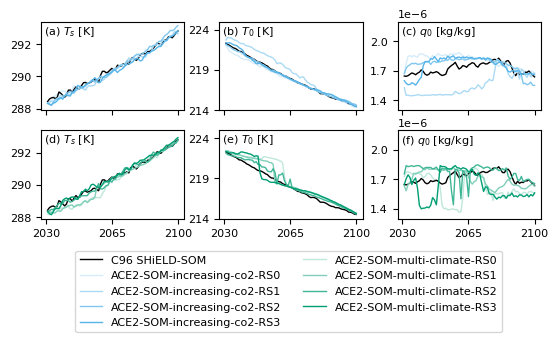

In [8]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = faceted.faceted(
    2,
    3,
    width=5.5,
    aspect=0.618,
    internal_pad=(0.35, 0.2),
    left_pad=0.4,
    right_pad=0.1,
    top_pad=0.2,
    bottom_pad=1.1,
    sharey="col"
)

BEST_EQUILIBRIUM_MODEL = "ACE2-SOM-multi-climate-RS3"
BEST_INCREASING_MODEL = "ACE2-SOM-increasing-co2-RS2"
LW = 1
LS = "-"

handles = {}

for ts_ax, t0_ax, q0_ax in [(ax1, ax2, ax3), (ax4, ax5, ax6)]:
    p, = ds.surface_temperature.sel(source="target").isel(model=0).plot(ax=ts_ax, color="k", label="C96 SHiELD-SOM", lw=LW, ls=LS)
    p, = ds.air_temperature_0.sel(source="target").isel(model=0).plot(ax=t0_ax, color="k", label="C96 SHiELD-SOM", lw=LW, ls=LS)
    p, = ds.specific_total_water_0.sel(source="target").isel(model=0).plot(ax=q0_ax, color="k", label="C96 SHiELD-SOM", lw=LW, ls=LS)

handles["C96 SHiELD-SOM"] = p

i = 0
for model in ds.model.isel(model=slice(4, None)):
    if model.item() == BEST_EQUILIBRIUM_MODEL:
        color = equilibrium_best_seed
        zorder = 4
        label = f"{model.item()} (best)"
    else:
        color = equilibrium_other_seeds[i]
        zorder = i + 1
        label = model.item()
        i += 1
    
    p, = ds.surface_temperature.sel(source="prediction", model=model).plot(ax=ax1, color=color, label=label, lw=LW, ls=LS, zorder=zorder)
    p, = ds.air_temperature_0.sel(source="prediction", model=model).plot(ax=ax2, color=color, label=label, lw=LW, ls=LS, zorder=zorder)
    p, = ds.specific_total_water_0.sel(source="prediction", model=model).plot(ax=ax3, color=color, label=label, lw=LW, ls=LS, zorder=zorder)

    handles[label] = p

i = 0
for model in ds.model.isel(model=slice(None, 4)):
    if model.item() == BEST_INCREASING_MODEL:
        color = increasing_best_seed
        zorder = 4
        label = f"{model.item()} (best)"
    else:
        color = increasing_other_seeds[i]
        zorder = i + 1
        label = model.item()
        i += 1

    p, = ds.surface_temperature.sel(source="prediction", model=model).plot(ax=ax4, color=color, label=label, lw=LW, ls=LS, zorder=zorder)
    p, = ds.air_temperature_0.sel(source="prediction", model=model).plot(ax=ax5, color=color, label=label, lw=LW, ls=LS, zorder=zorder)
    p, = ds.specific_total_water_0.sel(source="prediction", model=model).plot(ax=ax6, color=color, label=label, lw=LW, ls=LS, zorder=zorder)

    handles[label] = p

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")

ax2.set_ylim([214, 225])
ax2.set_yticks([214, 219, 224])
ax3.set_ylim([1.3e-6, 2.2e-6])
ax3.set_yticks([1.4e-6, 1.7e-6, 2.0e-6])

ax1.annotate(
    "(a) $T_s$ [K]",
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax2.annotate(
    "(b) $T_0$ [K]",
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax3.annotate(
    "(c) $q_0$ [kg/kg]",
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)

ax4.annotate(
    "(d) $T_s$ [K]",
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax5.annotate(
    "(e) $T_0$ [K]",
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax6.annotate(
    "(f) $q_0$ [kg/kg]",
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_xticks([2030, 2065, 2100])

ax4.legend(handles.values(), handles.keys(), bbox_to_anchor=(0.2, -0.3), bbox_transform=ax4.transAxes, loc="upper left", ncol=2, fontsize=8)

fig.savefig("figures/figure-12.png", dpi=200)
fig.savefig("figures/figure-12.pdf")